# <tt>synphot</tt>: Predicting count rates with ground-based and space-based telescopes

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using `astropy.coordinates.Skycoord`, `astroquery.Gaia`, `astropy.io`, and `astropy.utils`</li>
<li>Construct a source spectrum using `synphot.SourceSpectrum`</li>
<li>Simulate bandpass throughput with `synphot.SpectralElement`</li>
<li>Model effects on the source spectrum such as atmospheric transmission and quantum efficiency with `synphot.SpectralElement`</li>
<li>Combine all of these effects into a simulated observation with `synphot.Observation`</li>
<li>Compute the expected count rate from this observation with `synphot`'s `countrate()` function
</ul>

## Keywords
synphot, synthetic photometry, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#query_properties">Query the properties of our target star</a> (HAT-P-11 to start)</li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#bandpass">Create the bandpass of observation</a></li>
<li><a href="#atmosphere">Model attenuation by the atmosphere</a></li>
<li><a href="#qe">Model the effect of the quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
<li><a href="#kepler">Simulate observations with a space-based telescope</a></li>
<li><a href="#compare">Compare simulated counts to observed counts</a></li>
</ol>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia

from synphot import units
from synphot.models import Empirical1D
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.observation import Observation

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


<a id='query_properties'></a>
## 1. Query the properties of HAT-P-11

First we get the star's parameters using <a href="https://astroquery.readthedocs.io/en/latest/">astroquery's</a> <a href="https://astroquery.readthedocs.io/en/latest/gaia/gaia.html">Gaia query</a>: 

In [2]:
ID = 'HAT-P-11'

coord = SkyCoord.from_name(ID)
width = u.Quantity(1, u.arcmin)  # width / height of search
height = u.Quantity(1, u.arcmin)
search_results = Gaia.query_object_async(coordinate=coord, width=width, height=height)

# the queried star will be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

# now get the parameters
stellar_radius = hatp11_info['radius_val'] * u.R_sun
# divide 1 AU by parallax (arcseconds) to get distance in parsecs.
# parallax is given in milliarcseconds, so multiply by 1000: 
distance = (1 / (hatp11_info['parallax']) * 1000) * u.pc
T_eff = hatp11_info['teff_val']

Query finished.


<a id="phoenix"></a>
## 2. Download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [3]:
T_eff = round(T_eff, -2)  # round to nearest 100 K

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

<a id="source_spectrum"></a>
## 3. Construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

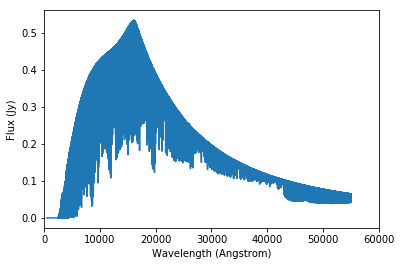

In [4]:
photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='Jy', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

<a id="bandpass"></a>
## Now we will simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/">ARCTIC instrument</a> on APO's 3.5m telescope.

In [5]:
aperture_radius = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
aperture_area = np.pi * aperture_radius ** 2
gain = 1.9  # the gain of this detector in e-/ADU

## 4.  Create the bandpass

For the bandpass we will use the SDSS r- and z- filters whose transmission functions we query from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a>. 
<p>To construct a bandpass from a file with <tt>synphot</tt>, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a>:</p>

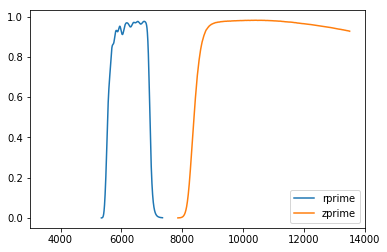

In [6]:
sdss = ['rprime', 'zprime']  # only want r' and z' bands for now
svo_sdss_link = 'http://svo2.cab.inta-csic.es/theory/fps' + \
                 '/getdata.php?format=ascii&id=SLOAN/SDSS.'

bandpasses = {}
for band in sdss:
    local_path = download_file(svo_sdss_link + band + '_filter')
    bp = SpectralElement.from_file(local_path)
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()
    

<a id="atmosphere"></a>
## 5. Model the attenuation by the atmosphere

Query from Cerro Paranal

In [7]:
# Set up parameters for the observing night in the format that skyclac_cli would use

# Use the bit from skycalc_cli which queries from Cerro Paranal

# Make a transmission function from it
# Don't write the output to a file, just let them be arrays

The following cells show how to simulate an atmospheric transmission profile at a given site and time of year. We use <a href="https://arxiv.org/abs/1806.09701">`pwv_kpno`</a>, a package that downloads data collected by SuomiNet on the precipitable water vapor in the atmosphere on a given night at the given location, and uses them to calculate the transmission as a function of wavelength. The list of sites from which data is collected can be seen <a href="https://www.suominet.ucar.edu/">here</a>.

This requires versions > 1.0.1 of `pwv_kpno`.

The next cell demonstrates how to configure a `pwv_kpno` observation site other than the default (aka Kitt Peak). Once this cell has been ran, it does not need to be ran again.

In [14]:
from pwv_kpno.package_settings import ConfigBuilder, settings
from pwv_kpno import pwv_atm
from datetime import datetime
import pytz
import os

if not os.path.isfile('./apache_point.ecsv'):
    # configure the new observation site
    new_config = ConfigBuilder(
                               site_name = "apache_point",
                               primary_rec="P027",  # the suominet receiver nearest APO
                               sup_rec = []
                              )
    new_config.save_to_ecsv('./apache_point.ecsv')
    settings.import_site_config('./apache_point.ecsv')

# change site from KPNO to APO
settings.set_site('apache_point')

# download data from SuomiNet from year observation was taken
pwv_atm.update_models(years=[2018])

[2018]

Then we combine with `synphot` so we can convolve the atmospheric effects with other parts of the observation:

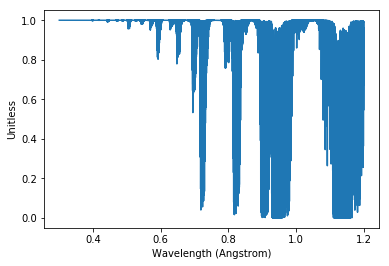

In [19]:
obsv_date = datetime(year=2018, month=5, day=15,  # set the date of observation, let's say mid-May
                     tzinfo = pytz.utc)
transmission = pwv_atm.trans_for_date(date=obsv_date, airmass=1.5)  # get the transmission function

atmosphere = SpectralElement(Empirical1D,
                             points=transmission['wavelength'],
                             lookup_table=transmission['transmission'])
atmosphere.plot()

<a id="qe"></a>
## 6. Model the affect of the CCD's quantum efficiency on the spectrum

For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

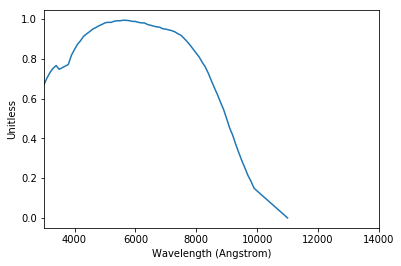

In [47]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to decimals

quantum_efficiency.plot(left=3000, right=14000)

<a id="observation"></a>
## 7. Combine all of the effects and "observe"

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

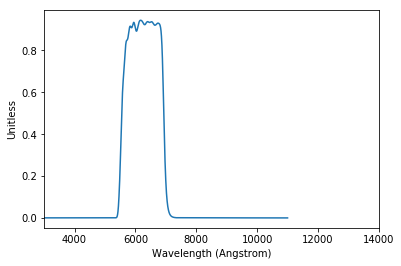

In [48]:
bp_atmos_qe = {} # setting up a dictionary for the different SDSS bands
for band in sdss:
    bp_atmos_qe[band] = bandpasses[band] * atmosphere * quantum_efficiency
    
bp_atmos_qe['rprime'].plot(left=3000, right=14000)

Finally, we convolve the source spectrum with all of these effects using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

In [75]:
band = 'rprime'  # only want to know about the r' band

observation = Observation(photlam_hatp11, bp_atmos_qe[band])

<a id="counts"></a>
## 8. Compute the count rate and total counts

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [63]:
countrate = observation.countrate(area=aperture_area) / gain

How many counts can we expect in a 10s exposure?

In [64]:
counts_hatp11 = countrate * 10 * u.s

print("HAT-P-11 counts in the r-band, 10 s exposure:")
print(int(counts_hatp11.value), "cts")

HAT-P-11 counts in the r-band, 10 s exposure:
44043008 cts


<a id="trappist1"></a>
## 9. Another example, this time with <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a>

(using the same instrument and telescope)

In [82]:
T_eff = 2600  # approx temperature of trappist-1 [K], Gillon 2017

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Unfortunately Gaia does not have all the parameters we need for TRAPPIST-1, so we use the values cited in <a href="https://arxiv.org/pdf/1703.01424.pdf">Gillon 2017</a>:

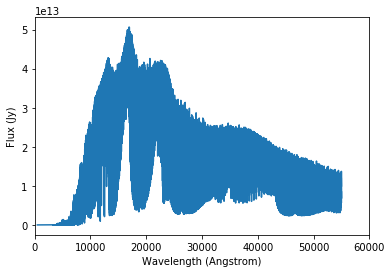

In [83]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
stellar_radius = 0.117 * u.R_sun  # radius of trappist-1 in solar units
distance = 12.1 * u.pc  # distance to trappist-1 in parsecs
photlam_trappist1 = photlam_trappist1 * (stellar_radius / distance).value ** 2 / np.pi

photlam_trappist1.plot(flux_unit='Jy', left=0, right=60000)

This time I just want to know about observations in the z-band:

In [84]:
band = 'zprime'
# observation = Observation(photlam_trappist1, 
#                       bp_atmos_qe[band],
#                       binset=bp_atmos_qe[band].waveset,
#                       force='taper')
observation = Observation(photlam_trappist1, 
                      bp_atmos_qe[band],
                      binset=bp_atmos_qe[band].waveset,
                      force='taper')

countrate = observation.countrate(area=aperture_area, waverange=waverange) / gain
counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts in the z-band, 10 s exposure:")
print(int(counts_trappist1.value), "cts")

TRAPPIST-1 counts in the z-band, 10 s exposure:
522921278184389214208 cts


## 10. Predicting count rates of the same stars, this time observed by a space-based telescope

The space telescope we will use as the example is <a href="https://en.wikipedia.org/wiki/Kepler_space_telescope">Kepler</a>.

First query Kepler's response function, which includes both the bandpass and the quantum efficiency:

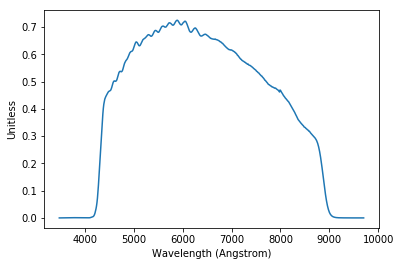

In [85]:
kepler_response_path = download_file('https://keplergo.arc.nasa.gov/kepler_response_hires1.txt')
kepler_response = SpectralElement.from_file(kepler_response_path, wave_unit=u.nm)
kepler_response.plot()

Create the observation object. Since Kepler is a space-based telescope, we do not need to convolve with the atmospheric transmission function:

In [86]:
stars = {'hatp11': {'spectrum': photlam_hatp11},
         'trappist1': {'spectrum': photlam_trappist1}
        }
for star in stars.keys():
    stars[star]['observation'] = Observation(stars[star]['spectrum'], 
                                  kepler_response,
                                  binset=kepler_response.waveset,
                                  force='taper')

Compute the countrates for the two stars:

In [87]:
kepler_area = np.pi * (1.4 * u.m / 2) ** 2  # area of Kepler's primary mirror
waverange = (kepler_response.waveset[0], kepler_response.waveset[-1])

for star in stars.keys():
    stars[star]['countrate'] = stars[star]['observation'].countrate(area=kepler_area,
                                                                    waverange=waverange)
print('synphot count rates:')
print('\t HAT-P-11:', round(stars['hatp11']['countrate'].value / 1e6, 1), 'million e-/s')
print('\t TRAPPIST-1', round(stars['trappist1']['countrate'].value / 1e3, 1), 'thousand e-/s')

synphot count rates:
	 HAT-P-11: 2.5 million e-/s
	 TRAPPIST-1 1.279131256718357e+16 thousand e-/s


<a id="compare"></a>
## 11. Comparing simulated counts to observed counts

We know from observations using AGILE on APO's 3.5m telescope that the actual count values for these stars taken on certain dates are:

In [88]:
hatp11_r_apo = 34000000
hatp11_kepler = 2800000
trappist1_z_apo = 203000
trappist1_kepler = 5700

In [89]:
print('Ground-based counts at Apache Point Observatory:')
print('\t HAT-P-11 in r-band:', int(hatp11_r_apo / 1e6), 'million counts')
print('\t TRAPPIST-1 in z-band:', int(trappist1_z_apo / 1e3), 'thousand counts')
print('Space-based count rates with Kepler:')
print('\t HAT-P-11:', round(hatp11_kepler / 1e6, 1), 'million e-/s')
print('\t TRAPPIST-1', round(trappist1_kepler / 1e3, 1), 'thousand e-/s')

Ground-based counts at Apache Point Observatory:
	 HAT-P-11 in r-band: 34 million counts
	 TRAPPIST-1 in z-band: 203 thousand counts
Space-based count rates with Kepler:
	 HAT-P-11: 2.8 million e-/s
	 TRAPPIST-1 5.7 thousand e-/s


Comparing our `synphot` values to the observed values on a 1-1 line:

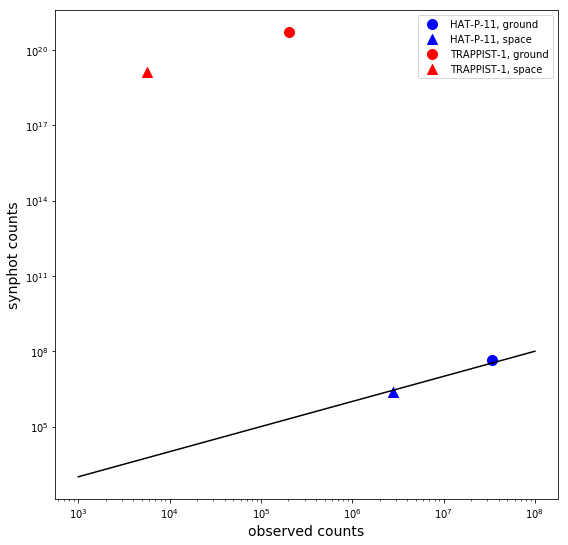

In [90]:
fig = plt.figure(figsize=(9, 9))

plt.scatter(hatp11_r_apo, counts_hatp11,
            color='b', s=100, label="HAT-P-11, ground")
plt.scatter(hatp11_kepler, stars['hatp11']['countrate'],
            color='b', marker= '^', s=100, label="HAT-P-11, space")
plt.scatter(trappist1_z_apo, counts_trappist1,
            color='r', s=100, label='TRAPPIST-1, ground')
plt.scatter(trappist1_kepler, stars['trappist1']['countrate'],
            color='r', marker= '^', s=100, label='TRAPPIST-1, space')

# one-to-one line
plt.plot(np.linspace(1e3, 1e8, 20), np.linspace(1e3, 1e8, 20), color='black')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('synphot counts', size='14')
plt.xlabel('observed counts', size='14')

plt.legend()